Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Params to learn:
	 classifier.6.weight
	 classifier.6.bias
num_epochs 1
0
loss = tensor(0.0058, grad_fn=<NllLossBackward>)
validation check: Y tensor([1, 1, 1, 1, 1, 0, 1, 0, 1, 1])
correct: 138
total: 153
Accuracy:  0.902


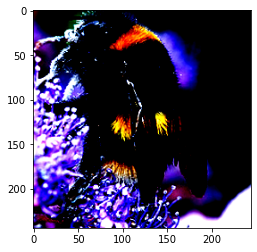

In [6]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
from torchvision import datasets, models, transforms
from torch.utils.data import Dataset, DataLoader
import os
import cv2
from tqdm import tqdm
import numpy as np
import matplotlib.pyplot as plt

#####################################  
##################################### 
##################################### 
# set model parameters 
def set_parameter_requires_grad(model, feature_extracting):
    if feature_extracting:
        for param in model.parameters():
            param.requires_grad = False

# load pre-trained models 
def initialize_model(model_name, num_classes, feature_extract, use_pretrained=True):
    # Initialize these variables which will be set in this if statement. Each of these
    #   variables is model specific.
    model_ft = None
    input_size = 0

    if model_name == "resnet":
        """ Resnet18
        """
        model_ft = models.resnet18(pretrained=use_pretrained)
        set_parameter_requires_grad(model_ft, feature_extract)
        num_ftrs = model_ft.fc.in_features
        model_ft.fc = nn.Linear(num_ftrs, num_classes)
        input_size = IMG_SIZE

    elif model_name == "alexnet":
        """ Alexnet
        """
        model_ft = models.alexnet(pretrained=use_pretrained)
        set_parameter_requires_grad(model_ft, feature_extract)
        num_ftrs = model_ft.classifier[6].in_features
        model_ft.classifier[6] = nn.Linear(num_ftrs,num_classes)
        input_size = IMG_SIZE

    elif model_name == "vgg":
        """ VGG11_bn
        """
        model_ft = models.vgg11_bn(pretrained=use_pretrained)
        set_parameter_requires_grad(model_ft, feature_extract)
        num_ftrs = model_ft.classifier[6].in_features
        model_ft.classifier[6] = nn.Linear(num_ftrs,num_classes)
        input_size = IMG_SIZE

    elif model_name == "squeezenet":
        """ Squeezenet
        """
        model_ft = models.squeezenet1_0(pretrained=use_pretrained)
        set_parameter_requires_grad(model_ft, feature_extract)
        model_ft.classifier[1] = nn.Conv2d(512, num_classes, kernel_size=(1,1), stride=(1,1))
        model_ft.num_classes = num_classes
        input_size = IMG_SIZE

    elif model_name == "densenet":
        """ Densenet
        """
        model_ft = models.densenet121(pretrained=use_pretrained)
        set_parameter_requires_grad(model_ft, feature_extract)
        num_ftrs = model_ft.classifier.in_features
        model_ft.classifier = nn.Linear(num_ftrs, num_classes) 
        input_size = IMG_SIZE

    elif model_name == "inception":
        """ Inception v3 
        Be careful, expects (299,299) sized images and has auxiliary output
        """
        model_ft = models.inception_v3(pretrained=use_pretrained)
        set_parameter_requires_grad(model_ft, feature_extract)
        # Handle the auxilary net
        num_ftrs = model_ft.AuxLogits.fc.in_features
        model_ft.AuxLogits.fc = nn.Linear(num_ftrs, num_classes)
        # Handle the primary net
        num_ftrs = model_ft.fc.in_features
        model_ft.fc = nn.Linear(num_ftrs,num_classes)
        #input_size = 299
        input_sizr = IMG_SIZE + 75

    else:
        print("Invalid model name, exiting...")
        exit()
    
    return model_ft, input_size

#####################################  
##################################### 
##################################### 
def validate_model_PRE(dataloader, model):
    
    correct = 0
    total = 0

    model.eval()  #set the model to evaluaiton mode
    
    with torch.no_grad():
        for k, data in enumerate(dataloader):
            X, Y = data
            a,b, width, height = X.size()          
            
            if k==0:
                #print("validation check: X size",X.size())
                #print("validation check: Y size",Y.size())
                #print("validation check: X", X)
                print("validation check: Y", Y)
                  
            output = model(X.float())
            #print(output)
            for idx, i in enumerate(output):
                #print(torch.argmax(i), y[idx])
                j = torch.argmax(i)
                if j == Y[idx]:
                    correct +=1
   
                #if torch.argmax(i) == y[idx]:
                #    correct += 1
                total += 1

    print("correct:", correct)
    print("total:",total)
    print("Accuracy: ", round(correct/total, 3))
    
#for training for MNIST Data
def train_model_PRE(dataloader, model, lossFunc, optimizer, num_epochs=25, dataloader_v=None):
    
    model.train() #set the model to training mode
    
    print("num_epochs",num_epochs)
    for epoch in range(num_epochs):  
        print(epoch)
        for k, (data,labels) in enumerate(dataloader): 
            
            X = data
            Y = labels
            
            bat_s, col_c, width, height = X.size()
            
            # predict = forward pass with our model
            #y_predicted = model(X.view(-1,3,width,height))
            y_predicted = model(X.float())
            #y_predicted = model(X)
            
            #batch_X = train_X[i:i+BATCH_SIZE].view(-1, 1, 50, 50)
            #outputs = net(batch_X)

            # loss
            l = lossFunc(y_predicted, Y)
            #l = lossFunc(y_predicted.float(), Y.float())           
            #l = F.nll_loss(y_predicted, Y)   #bad don't know why

            # calculate gradients = backward pass
            l.backward()

            # update weights
            optimizer.step()

            # zero the gradients after updating
            optimizer.zero_grad()
          
        print("loss =",l)
        #print(model.parameters())
        #[w, b] = model.parameters() # unpack parameters
        #print('epoch ', epoch+1, ': w = ', w[0][0].item(), ' loss = ', l)
        validate_model_PRE(dataloader_v, model)
        
def PRE_Demo():
 
    ####### hymenoptera_data 
    dataset = torchvision.datasets.ImageFolder('./hymenoptera_data/train',
                                transform=transforms.Compose([
                                    transforms.RandomResizedCrop(IMG_SIZE),
                                    transforms.RandomHorizontalFlip(),
                                    transforms.ToTensor(),
                                    transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225)),
                                ]))
    dataloader = torch.utils.data.DataLoader(dataset, batch_size=4, shuffle=True, num_workers=4)
    
    dataset_v = torchvision.datasets.ImageFolder('./hymenoptera_data/val',
                                transform=transforms.Compose([
                                    transforms.Resize(IMG_SIZE),
                                    transforms.CenterCrop(IMG_SIZE),
                                    transforms.ToTensor(),
                                    transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225)),
                                ]))
    dataloader_v = torch.utils.data.DataLoader(dataset_v, batch_size=10, shuffle=True)
      
    dataiter = iter(dataloader)                
    data = dataiter.next()
 
    a,b,xsize,ysize = data[0].size()
    a = data[1].size()
    im = data[0][1]


    plt.imshow(im.permute(1, 2, 0))
    
    # Initialize the model for this run
    #model_name = "resnet"
    #model_name = "vgg"
    model_name = "alexnet"
    #model_name ="squeezenet"
    #model_name = "densenet"
    num_classes = 2
    feature_extract = True
    
    model, input_size = initialize_model(model_name, num_classes, feature_extract, use_pretrained=True)
    # Print the model we just instantiated
    ##print(model)
    
    # Gather the parameters to be optimized/updated in this run. If we are
    #  finetuning we will be updating all parameters. However, if we are 
    #  doing feature extract method, we will only update the parameters
    #  that we have just initialized, i.e. the parameters with requires_grad
    #  is True.
    params_to_update = model.parameters()
    print("Params to learn:")
    if feature_extract:
        params_to_update = []
        for name,param in model.named_parameters():
            if param.requires_grad == True:
                params_to_update.append(param)
                print("\t",name)
    else:
        for name,param in model.named_parameters():
            if param.requires_grad == True:
                print("\t",name)

    learning_rate = 0.001
    n_iters = 100
    num_epochs = 15

    #loss = nn.MSELoss()
    loss = nn.CrossEntropyLoss()
    #optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
    optimizer = torch.optim.SGD(params_to_update, lr=learning_rate, momentum=0.9)

    #train_model(dataloader, model, loss, optimizer, scheduler, num_epochs=25)
    train_model_PRE(dataloader, model, loss, optimizer, num_epochs, dataloader_v)
 

PRE_Demo()


In [36]:
print(torch.__version__)

1.3.1
